In [1]:
import os
os.chdir("../")

import semiolog as slg

In [2]:
from collections import defaultdict, Counter
import string
import itertools
import numpy as np
from tqdm.notebook import tqdm as n_tqdm
from tqdm.notebook import trange
from tqdm import tqdm
from math import log
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn import decomposition
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
import sparse
from joblib import Parallel, delayed
import operator
from functools import reduce
from os import cpu_count
from numpy.linalg import svd
from ipywidgets import interact

sns.set(rc = {'figure.figsize':(30,4)})

In [3]:
level = "chars"

if level == "tags":
    ng1 = slg.util.load_file("wip/res_bnc/ng_t_1.json")
    ng2 = slg.util.load_file("wip/res_bnc/ng_t_2.json")
    ng3 = slg.util.load_file("wip/res_bnc/ng_t_3.json")
    ng4 = slg.util.load_file("wip/res_bnc/ng_t_4.json")

elif level == "words":
    ng1 = slg.util.load_file("wip/res_bnc/ng_w_1.json")
    ng2 = slg.util.load_file("wip/res_bnc/ng_w_2.json")
    ng3 = slg.util.load_file("wip/res_bnc/ng_w_3_5.json")
    ng4 = slg.util.load_file("wip/res_bnc/ng_w_4_5.json")

elif level == "chars":
    ng1 = slg.util.load_file("models/en_bnc/vocabulary/alpha.json")
    ng2 = slg.util.load_file("models/en_bnc/vocabulary/ngrams/big_ng/2.json")
    ng3 = slg.util.load_file("models/en_bnc/vocabulary/ngrams/big_ng/3.json")
    ng4 = slg.util.load_file("models/en_bnc/vocabulary/ngrams/big_ng/4.json")


In [4]:
thres = 10

if level == "chars":

    ng1 = {k:v for k,v in ng1.items() if v>=thres}
    ng2 = {tuple(list(k)):v for k,v in ng2.items() if v>=thres}
    ng3 = {tuple(list(k)):v for k,v in ng3.items() if v>=thres}
    ng4 = {tuple(list(k)):v for k,v in ng4.items() if v>=thres}
    
elif level == "words":
    ng2 = {tuple(k.split()):v for k,v in ng2.items() if v>=thres}
    ng3 = {tuple(k.split()):v for k,v in ng3.items() if v>=thres}
    ng4 = {tuple(k.split()):v for k,v in ng4.items() if v>=thres}

    ng2 = {k:v for k,v in ng2.items() if len(k)>1 and all([kn not in ",.'‘’?!"+string.punctuation for kn in k])}
    ng3 = {k:v for k,v in ng3.items() if len(k)>2 and all([kn not in ",.'‘’?!"+string.punctuation for kn in k])}
    ng4 = {k:v for k,v in ng4.items() if len(k)>3 and all([kn not in ",.'‘’?!"+string.punctuation for kn in k])}

else:    
    ng2 = {tuple(k.split()):v for k,v in ng2.items() if v>=thres}
    ng3 = {tuple(k.split()):v for k,v in ng3.items() if v>=thres}
    ng4 = {tuple(k.split()):v for k,v in ng4.items() if v>=thres}

In [5]:
if level == "chars":
    elements = string.ascii_lowercase+string.digits
    
else:
    elements = ng1.keys()

if level == "words":
    elements = [e for e in elements if e not in ",.'‘’?!"+string.punctuation][:1000]

elements = list(elements) + [" "]
elements_dict = {k:i for i,k in enumerate(elements)}
elements_len = len(elements)

In [6]:
ng_total_freq = sparse.DOK([elements_len]*4, dtype=np.int64)

for (l,r),v in n_tqdm(ng2.items(), total=len(ng2)):
        if set((l,r)).issubset(set(elements)):
                ng_total_freq[
                        elements_dict[" "],
                        elements_dict[" "],
                        elements_dict[l],
                        elements_dict[r]
                        ] = v

for (l,c,r),v in n_tqdm(ng3.items(), total=len(ng3)):
        if set((l,c,r)).issubset(set(elements)):
                ng_total_freq[
                        elements_dict[l],
                        elements_dict[" "],
                        elements_dict[c],
                        elements_dict[r]
                        ] = v
                ng_total_freq[
                        elements_dict[" "],
                        elements_dict[r],
                        elements_dict[l],
                        elements_dict[c]
                        ] = v
                        
for (cl,tl,tr,cr),v in n_tqdm(ng4.items(), total=len(ng4)):
        if set((cl,tl,tr,cr)).issubset(set(elements)):
                ng_total_freq[
                        elements_dict[cl],
                        elements_dict[cr],
                        elements_dict[tl],
                        elements_dict[tr]
                        ] = v

  0%|          | 0/2314 [00:00<?, ?it/s]

  0%|          | 0/31457 [00:00<?, ?it/s]

  0%|          | 0/204959 [00:00<?, ?it/s]

In [7]:
def sparse_tensor_builder(
    context_pairs,
    ng_total_freq,
    thres = .2,
    ):
    
    ng_total = sparse.DOK([*ng_total_freq.shape,4], dtype=bool)

    for cl_i, cr_i in tqdm(context_pairs):
        term_matrix = ng_total_freq[cl_i, cr_i]
        norm = sum(term_matrix.data.values())
        
        if norm != 0:
            lr_probs = (term_matrix/norm).data
            l_probs = slg.util.marginalize(lr_probs,side="left")
            r_probs = slg.util.marginalize(lr_probs,side="right")

            for (tl_i, tr_i), p_lr in lr_probs.items():

                    p_l = l_probs[tl_i]
                    p_r = r_probs[tr_i]

                    l_sel_r = p_lr/p_l
                    r_sel_l = p_lr/p_r

                    if l_sel_r <= thres:
                        if r_sel_l <= thres:
                            connective_i = 3
                        else:
                            connective_i = 1
                    else:
                        if r_sel_l <= thres:
                            connective_i = 2
                        else:
                            connective_i = 0
                    
                    ng_total[cl_i, cr_i, tl_i, tr_i, connective_i] = 1

    return ng_total

In [8]:

def build_sparse_tensor(
    ng_total_freq,
    thres = .2,
    parallel = False,
    cores = None,
    ):

    # context_pairs = [(i,j) for i in range(ng_total_freq.shape[0]) for j in range(ng_total_freq.shape[1])]
    
    context_pairs = sorted(list({(cl,cr) for cl, cr, tl, tr in ng_total_freq.data.keys()}))
    
    if parallel:

        if cores == None:
            cores = cpu_count()

        chunks = slg.util.partition(context_pairs,cores)

        with Parallel(n_jobs=cores) as parallel_pool:
            
            jobs_data = parallel_pool(delayed(sparse_tensor_builder)(
                pairs,
                ng_total_freq,
                thres
                ) for pairs in
                chunks)

            ng_total = reduce(operator.add,jobs_data)
    
    else:
        ng_total = sparse_tensor_builder(context_pairs,ng_total_freq,thres)
    
    return ng_total

In [9]:
ng_total = build_sparse_tensor(ng_total_freq, thres = .15, parallel=True)

100%|██████████| 170/170 [00:49<00:00,  3.41it/s]


In [ ]:
sparse.save_npz("/Users/Gianni/Desktop/test.npz",ng_total.to_coo())

In [14]:
# ng_total = ng_total.to_coo()
ng_total_test = sparse.load_npz("/Users/Gianni/Desktop/test.npz")

In [15]:
ng_total_test.shape

(37, 37, 37, 37, 4)

In [10]:
spectrum_total = np.empty((0,(len(elements)-1)*2))
norms_total = np.empty((0,6))

context_dict = defaultdict()

for tl_i in trange(len(elements)-1):
    connective_spectrum_r = []
    connective_spectrum_l = []
    for connective in range(3):
        # Take tensor corresponding to the element on L and R
        ortho_tensor_r = ng_total[:-1,:-1,:-1,tl_i,connective]
        ortho_tensor_l = ng_total[:-1,:-1,tl_i,:-1,connective]
        # Transform tensor to COO format and reshape into a matrix contexts x ortho elements x connectives
        ortho_tensor_r = ortho_tensor_r.to_coo()
        ortho_tensor_l = ortho_tensor_l.to_coo()
        ortho_matrix_r = ortho_tensor_r.reshape((ortho_tensor_r.shape[0]**2,ortho_tensor_r.shape[-1]))
        ortho_matrix_l = ortho_tensor_l.reshape((ortho_tensor_l.shape[0]**2,ortho_tensor_l.shape[-1]))

        # Cluster row vectors in 4, to distinguish 4 types of contexts
        contexts_kmeans_r = KMeans(n_clusters=4, random_state=0).fit(ortho_matrix_r.tocsr())
        contexts_kmeans_l = KMeans(n_clusters=4, random_state=0).fit(ortho_matrix_l.tocsr())

        # If cluster < 4 (default number), pad
        context_k_matrice_r = contexts_kmeans_r.cluster_centers_ if contexts_kmeans_r.cluster_centers_.shape[0]==4 else np.pad(contexts_kmeans_r.cluster_centers_, ((0, 4-contexts_kmeans_r.cluster_centers_.shape[0])), 'constant', constant_values=0)
        context_k_matrice_l = contexts_kmeans_l.cluster_centers_ if contexts_kmeans_l.cluster_centers_.shape[0]==4 else np.pad(contexts_kmeans_l.cluster_centers_, ((0, 4-contexts_kmeans_l.cluster_centers_.shape[0])), 'constant', constant_values=0)

        # Add the vector resulting from the sum over contexts to the collector empty matrix

        
        connective_spectrum_r.append(context_k_matrice_r)
        connective_spectrum_l.append(context_k_matrice_l)

        # Add info about contexts to the context dict
        context_dict[(tl_i,connective,0)] = contexts_kmeans_r.labels_
        context_dict[(tl_i,connective,1)] = contexts_kmeans_l.labels_

        # # Add the vector resulting from the sum over contexts to the collector empty matrix
        # connective_spectrum_r.append(ortho_matrix_r.sum(axis=0).todense())
        # connective_spectrum_l.append(ortho_matrix_l.sum(axis=0).todense())

    # Normalize each vector
    connective_spectrum_r, norms_r = normalize(np.vstack(connective_spectrum_r),norm="l1",axis=1,return_norm=True)
    connective_spectrum_l, norms_l = normalize(np.vstack(connective_spectrum_l),norm="l1",axis=1,return_norm=True)

    # # Normalize the norms
    # norms_norm_r = normalize([norms_r],norm="l1")
    # norms_norm_l = normalize([norms_l],norm="l1")

    # Stack L and R and corresponding norms
    spectrum_total = np.vstack([spectrum_total,np.hstack([connective_spectrum_l,connective_spectrum_r])])
    norms_total = np.vstack([norms_total,np.hstack([norms_norm_l,norms_norm_r])])


  0%|          | 0/36 [00:00<?, ?it/s]

NameError: name 'norms_norm_l' is not defined

In [ ]:
spect_0_l.shape

(36, 36)

In [ ]:
spect_0_l, spect_1_l, spect_2_l = [[np.array(spectrum_total[(j*4)+i::12,:elements_len-1]) for i in range(4)] for j in range(3)]
spect_0_r, spect_1_r, spect_2_r = [[np.array(spectrum_total[(j*4)+i::12,elements_len-1:]) for i in range(4)] for j in range(3)]


# spect_0_r = spectrum_total[::12,elements_len-1:]
# spect_1_l = spectrum_total[1::12,:elements_len-1]
# spect_1_r = spectrum_total[1::12,elements_len-1:]
# spect_2_l = spectrum_total[2::12,:elements_len-1]
# spect_2_r = spectrum_total[2::12,elements_len-1:]

In [89]:
spect_0_l.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
context_dict

defaultdict(None,
            {(0, 0, 0): array([1, 1, 2, ..., 1, 1, 1], dtype=int32),
             (0, 0, 1): array([0, 0, 0, ..., 1, 0, 0], dtype=int32),
             (0, 1, 0): array([1, 1, 1, ..., 1, 1, 1], dtype=int32),
             (0, 1, 1): array([3, 3, 3, ..., 3, 3, 3], dtype=int32),
             (0, 2, 0): array([3, 1, 1, ..., 3, 3, 3], dtype=int32),
             (0, 2, 1): array([1, 1, 0, ..., 0, 0, 2], dtype=int32),
             (1, 0, 0): array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
             (1, 0, 1): array([1, 1, 1, ..., 1, 1, 1], dtype=int32),
             (1, 1, 0): array([1, 2, 1, ..., 1, 1, 1], dtype=int32),
             (1, 1, 1): array([0, 0, 2, ..., 0, 0, 0], dtype=int32),
             (1, 2, 0): array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
             (1, 2, 1): array([0, 2, 2, ..., 1, 1, 1], dtype=int32),
             (2, 0, 0): array([2, 2, 1, ..., 2, 2, 2], dtype=int32),
             (2, 0, 1): array([1, 0, 1, ..., 0, 0, 0], dtype=int32),
             (2,

In [86]:
def plot(vector):
    return sns.heatmap(vector, xticklabels=elements[:-1])#,yticklabels=elements[:-1])

In [14]:
    
def keys_queries(c_l,e_l,e_r,c_r):

    context_i_r = context_dict[,1]

    tl_i = [elements_dict[i] for i in e_l]
    context_i_l = context_dict[tl_i,0]
    
    queries_L = np.vstack([spect[tl_i].prod(axis=0) for spect in [spect_0_l, spect_1_l, spect_2_l]])
    keys_L = np.vstack([(spect*queries_L[i][:, np.newaxis]) for i,spect in enumerate([spect_0_r,spect_1_r,spect_2_r])])

    tr_i = [elements_dict[i] for i in e_r]
    queries_R = np.vstack([spect[tr_i].prod(axis=0) for spect in [spect_0_r, spect_1_r, spect_2_r]])
    keys_R = np.vstack([(spect*queries_R[i][:, np.newaxis]) for i,spect in enumerate([spect_0_l,spect_1_l,spect_2_l])])

    return queries_L, keys_L, queries_R, keys_R

def ortho_tup(c_l,e_l,e_r,c_r):

    queries_L, keys_L, queries_R, keys_R = keys_queries(c_l,e_l,e_r,c_r)

    connective_scores = (queries_L*keys_R).sum(-1)*((queries_R*keys_L).sum(-1)[[0,2,1]])
    
    print(connective_scores)
    connective = np.argmax(connective_scores)

    return [(connective,connective_scores[connective]),keys_L[connective],keys_R[connective]]

In [15]:
queries_L, keys_L, queries_R, keys_R = keys_queries("a","b")

<AxesSubplot:>

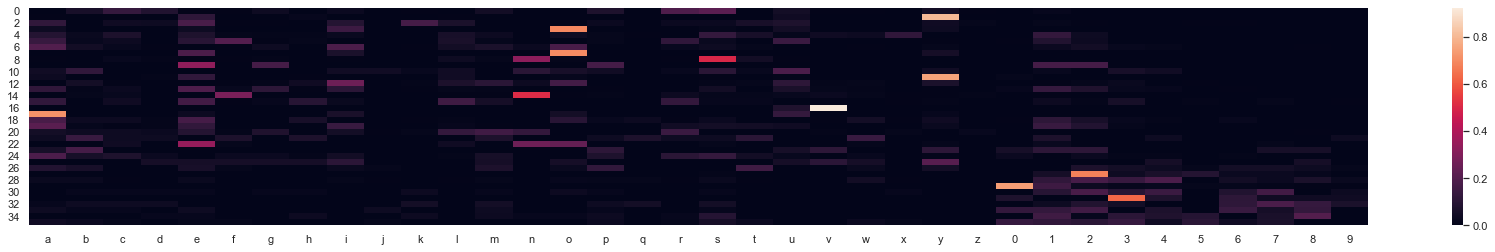

In [67]:
plot(spect_0_l)

<AxesSubplot:>

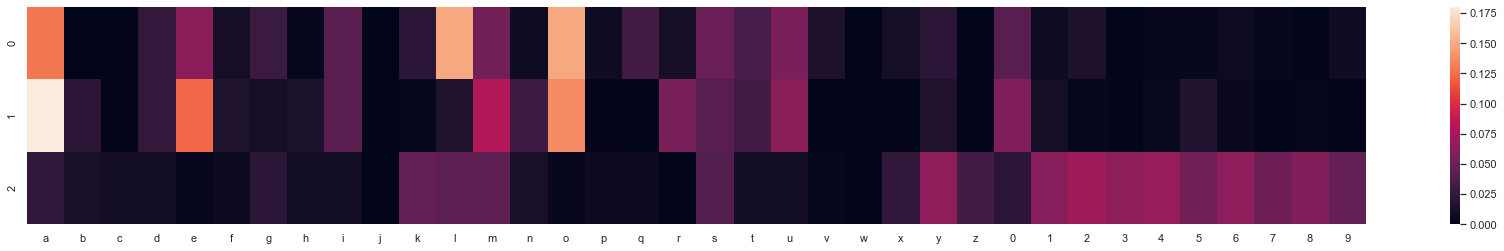

In [18]:
plot(queries_R)

In [42]:
sent = "1980"
for l,r in zip(sent,sent[1:]):
    connective,keys_L,keys_R = ortho_pair(l,r)
    print(l,r,connective)
    # ax = sns.heatmap([keys_L,keys_R], xticklabels=elements[:-1])#,yticklabels=elements[:-1])

[0.03946643 0.00275762 0.00807197]
1 9 (0, 0.03946643195292947)
[0.0102745  0.00346975 0.00975722]
9 8 (0, 0.01027450190444083)
[0.01011984 0.00458995 0.01368466]
8 0 (2, 0.013684657487510642)


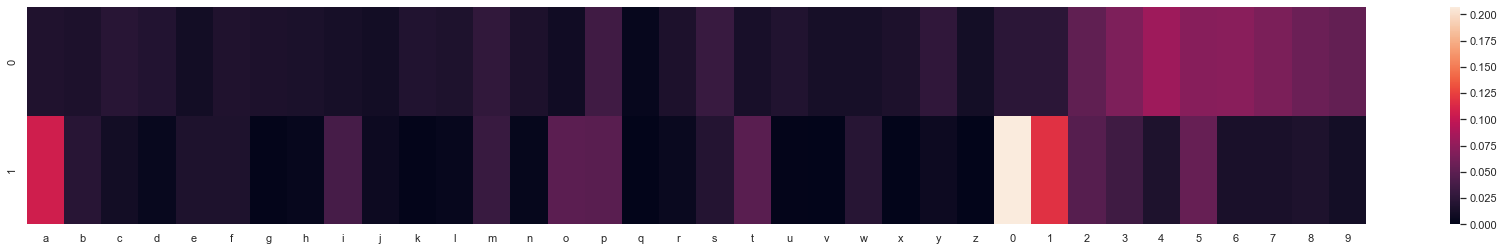

In [43]:
ax = sns.heatmap([keys_L,keys_R], xticklabels=elements[:-1])#,yticklabels=elements[:-1])

In [12]:
e_l = ["h"]
biortho_i = [elements_dict[i] for i in e_l]
tl_i = []

while not np.array_equal(tl_i,biortho_i):

    tl_i = biortho_i
    ortho = spect_1_l[tl_i]
    ortho_prod = ortho.prod(axis=0)
    ortho_i = np.where(ortho_prod>ortho_prod.mean()*3)
    biortho = [(spect_2_r[ortho_i].prod(axis=0))]
    biortho_i = np.where(biortho[0]>biortho[0].mean())

print([elements[i] for i in biortho_i[0]])
print([elements[i] for i in ortho_i[0]])

[]
[]


In [ ]:
nzi = np.where(ortho_matrix.sum(axis=1)>0)
contexts_kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(ortho_matrix[nzi].tocsr())
sns.set(rc = {'figure.figsize':(30,4)})
ax = sns.heatmap(contexts_kmeans.cluster_centers_, xticklabels=elements[:-1])

In [108]:
ortho_matrix.sum(axis=0).todense().tolist()

[169,
 4,
 1,
 2,
 319,
 0,
 0,
 0,
 75,
 0,
 0,
 32,
 8,
 1,
 129,
 1,
 0,
 103,
 18,
 17,
 41,
 0,
 2,
 0,
 126,
 0,
 1,
 22,
 8,
 1,
 1,
 1,
 0,
 0,
 1,
 1]

In [99]:
a = contexts_kmeans.cluster_centers_
[np.extract(a[i]>a[i].mean(),[elements]*4) for i in range(a.shape[0])]

[array(['a', 'e', 'i', 'o'], dtype='<U1'),
 array(['b', 'c', 'h', 'i', 'n', 's', 't', 'u', 'w', 'y', '1', '2'],
       dtype='<U1'),
 array(['e', 'i', 'o', 'u'], dtype='<U1'),
 array(['a', 'h', 'i', 'o'], dtype='<U1')]

In [ ]:
ortho_keys = .data.keys()
ortho_ids = sorted([tr for cl,cr,tl,tr in ortho_keys])


bi_ortho_keys = ng_total[:-1,:-1,:-1,ortho_ids,connective].data.keys()
bi_ortho_ids = [tl for cl,cr,tl,tr in bi_ortho_keys]

# Counter([tuple([elements[element] for element in tup[2:]]) for tup in test_connective]).most_common()

In [205]:
len(bi_ortho_keys)

1404736

In [207]:
bi_ortho_matrix = sparse.DOK((elements_len-1,elements_len-1))

for tup in n_tqdm(bi_ortho_keys):
    bi_ortho_matrix[tup[-2],ortho_ids[tup[-1]]] += 1

  0%|          | 0/1404736 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
bi_ortho_matrix_dense = bi_ortho_matrix.todense()
bi_ortho_matrix

Format,dok
Data Type,float64
Shape,"(1000, 1000)"
nnz,1396
Density,0.001396
Read-only,False
Size,10.9K
Storage ratio,0.0


In [ ]:
U, s, Vh = svd(bi_ortho_matrix_dense)

In [ ]:
Tn = 0
T_sign = -1

type_L = sorted([(round(score*T_sign,2),term) for term, score in zip(elements,U.T[Tn])], reverse=True)
type_R = sorted([(round(score*T_sign,2),context) for context, score in zip(elements,Vh[Tn])], reverse=True)
slg.util.df([type_L[:15],type_R[:15]])

,0,1
0,"(0.45, up)","(0.91, and)"
1,"(0.34, go)","(0.39, to)"
2,"(0.23, it)","(0.09, in)"
3,"(0.19, more)","(0.04, on)"
4,"(0.18, in)","(0.04, for)"
5,"(0.16, you)","(-0.0, …)"
6,"(0.16, try)","(-0.0, —)"
7,"(0.15, have)","(-0.0, yourself)"
8,"(0.14, time)","(-0.0, your)"
9,"(0.14, men)","(-0.0, young)"


In [170]:
contexts_kmeans = KMeans(n_clusters=4, random_state=0).fit(bi_ortho_matrix_dense)
contexts_kmeans_ortho = KMeans(n_clusters=4, random_state=0).fit(bi_ortho_matrix_dense.T)

In [169]:
[elements[i] for i,v in enumerate(contexts_kmeans.cluster_centers_[1]) if v>0.1]

['life',
 'part',
 'old',
 'family',
 'room',
 'mind',
 'view',
 'office',
 'mother',
 'father',
 'experience',
 'heart',
 'son']

In [176]:
[elements[i] for i,v in enumerate(contexts_kmeans_ortho.cluster_centers_[3]) if v>0.2]

['the', 'a', 'in', 'his', "n't", 'her', 'my', 'good']

In [149]:
pca = decomposition.PCA(n_components=3)
pca.fit(bi_ortho_matrix_dense)
context_PCA = pca.transform(bi_ortho_matrix_dense)
contexts_kmeans_PCA = KMeans(n_clusters=8, random_state=0).fit(context_PCA)


In [150]:
df = pd.DataFrame({
'cat':[str(c) for c in contexts_kmeans_PCA.labels_], 'labels':elements[:-1], '1st':context_PCA[:,0], '2nd':context_PCA[:,1], '3rd':context_PCA[:,2]
})
fig_contexts = px.scatter_3d(df, x='1st', y='2nd', z='3rd',
                    color='cat',
                    hover_name= "labels",
                    title="PCA Contexts",
                    width=1000, height=1000,)
fig_contexts.show()

In [132]:
ng_total[:-1,:-1,[elements_dict[term_l]],:-1,connective].todense().sum(axis=(0,1,2))

array([ 0, 93,  8,  4,  0,  5, 11,  1,  6,  0,  1,  7,  2,  0,  2,  3,  0,
        0,  1,  2,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  1,  3,
        0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  5,  0,  0,  1,  1,  0,  0,
        6,  0,  0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  6,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  0,  0,  0,  0,  0,  0,
        0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  0,
        1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  2,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  4,  0,  0

In [117]:
biortho_dict = defaultdict(set)
for tup in bi_ortho_keys:
    biortho_dict[elements[ortho_ids[tup[-1]]]] = biortho_dict[elements[ortho_ids[tup[-1]]]].union({elements[tup[-2]]})

biortho_dict

defaultdict(set,
            {'is': {"'s",
              'a',
              'act',
              'action',
              'again',
              'all',
              'answer',
              'approach',
              'big',
              'bill',
              'book',
              'britain',
              'building',
              'business',
              'but',
              'c',
              'car',
              'case',
              'certainly',
              'chapter',
              'child',
              'church',
              'claim',
              'colour',
              'community',
              'company',
              'consider',
              'contract',
              'council',
              'country',
              'course',
              'court',
              'date',
              'day',
              'difference',
              'easy',
              'economy',
              'effect',
              'else',
              'england',
              'environment',
         

In [95]:
biortho_dict

defaultdict(list, {14: []})

In [70]:
ng_total[-1,-1,108:109,:,:].data

{(0, 0, 3): True,
 (0, 1, 3): True,
 (0, 2, 3): True,
 (0, 3, 3): True,
 (0, 4, 3): True,
 (0, 5, 3): True,
 (0, 6, 3): True,
 (0, 7, 3): True,
 (0, 8, 3): True,
 (0, 9, 3): True,
 (0, 10, 3): True,
 (0, 11, 3): True,
 (0, 13, 3): True,
 (0, 14, 3): True,
 (0, 15, 3): True,
 (0, 16, 3): True,
 (0, 17, 3): True,
 (0, 18, 3): True,
 (0, 19, 3): True,
 (0, 20, 3): True,
 (0, 21, 3): True,
 (0, 22, 3): True,
 (0, 23, 3): True,
 (0, 24, 3): True,
 (0, 25, 3): True,
 (0, 26, 3): True,
 (0, 27, 3): True,
 (0, 28, 3): True,
 (0, 29, 3): True,
 (0, 30, 3): True,
 (0, 31, 3): True,
 (0, 32, 3): True,
 (0, 33, 3): True,
 (0, 34, 3): True,
 (0, 35, 3): True,
 (0, 37, 3): True,
 (0, 38, 3): True,
 (0, 39, 3): True,
 (0, 40, 3): True,
 (0, 41, 3): True,
 (0, 42, 3): True,
 (0, 43, 3): True,
 (0, 44, 3): True,
 (0, 45, 3): True,
 (0, 46, 3): True,
 (0, 47, 3): True,
 (0, 48, 3): True,
 (0, 49, 3): True,
 (0, 50, 3): True,
 (0, 51, 3): True,
 (0, 52, 3): True,
 (0, 53, 3): True,
 (0, 54, 3): True,
 (0

In [54]:
ng_total[0, 3, 107, 0]

Format,dok
Data Type,bool
Shape,"(4,)"
nnz,0
Density,0.0
Read-only,False
Size,0
Storage ratio,0.0


In [39]:
ng_total[1:3,:,elements_dict["my"]:elements_dict["my"]+1,:,1].data

{(0, 12, 790): True,
 (0, 605, 172): True,
 (0, 1000, 691): True,
 (0, 1000, 974): True,
 (1, 1000, 380): True,
 (1, 1000, 420): True,
 (1, 1000, 618): True,
 (1, 1000, 745): True,
 (1, 1000, 974): True}

In [126]:

test_connective = list(ng_total[
    elements_dict[" "],
    elements_dict[" "],
    :,#elements_dict["b"],
    :,
    2,#:,
    ].data.keys())

Counter([tuple([elements[element] for element in tup]) for tup in test_connective]).most_common()
# Counter(test_connective).most_common()
# test_connective

[(('b', 'e'), 1),
 (('h', 'e'), 1),
 (('j', 'o'), 1),
 (('j', 'u'), 1),
 (('k', 'e'), 1),
 (('m', 'e'), 1),
 (('q', 'u'), 1),
 (('r', 'e'), 1),
 (('v', 'e'), 1),
 (('w', 'a'), 1),
 (('x', 'p'), 1),
 (('z', 'e'), 1),
 (('5', '0'), 1)]

In [112]:
term_matrix = ng_total_freq[-1, -1]
norm = sum(term_matrix.data.values())

401988571

In [113]:

lr_probs = (term_matrix/norm).data
l_probs = slg.util.marginalize(lr_probs,side="left")
r_probs = slg.util.marginalize(lr_probs,side="right")


In [115]:

for (tl_i, tr_i), p_lr in lr_probs.items():

        p_l = l_probs[tl_i]
        p_r = r_probs[tr_i]

        l_sel_r = p_lr/p_l
        r_sel_l = p_lr/p_r

        if l_sel_r <= thres:
            if r_sel_l <= thres:
                connective_i = 3
            else:
                connective_i = 1
        else:
            if r_sel_l <= thres:
                connective_i = 2
            else:
                connective_i = 0
        print(connective_i)
        # ng_total[cl_i, cr_i, tl_i, tr_i, connective_i] = 1

3
3
3
3
3
3
3
3
3
3
3
1
3
1
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
1
3
3
3
3
3
3
3
3
3
3
3
3
1
1
1
3
3
1
3
1
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
0
3
3
3
3
3
3
3
1
3
3
3
1
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
3
3
3
3
3
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
1
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
1
3
3
1
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


In [6]:
context_functional_distr = defaultdict()

cl_list = []
for c_l in tqdm(elements):
    cl_list = []
    for c_r in elements:

        if c_l == " " and c_r == " ":
            lr_joint = ng2
        elif c_l == " ":
            lr_joint = {k[0:2]:v for k,v in ng3.items() if k[0]==c_r}
        elif c_r == " ":
            lr_joint = {k[1:3]:v for k,v in ng3.items() if k[0]==c_l}
        else:
            lr_joint = {k[1:3]:v for k,v in ng4.items() if k[0]==c_l and k[-1]==c_r}
        

        lr_joint = slg.util.normalize_dict(lr_joint)

        l_marginal = slg.util.marginalize(lr_joint,side="left")
        r_marginal = slg.util.marginalize(lr_joint,side="right")
        x = []
        y = []
        z = []
        
        labels = []

        for l in elements:
            for r in elements:
                
                p_lr = lr_joint.get((l,r),0)
                p_l = l_marginal.get(l,0)
                p_r = r_marginal.get(r,0)

                if p_lr * p_l * p_r == 0:
                    # TODO: Double-check what is convenient to decide in case of 0
                    l_sel_r = r_sel_l = 0
                    l_sol_r = -1
                elif log(p_lr/(p_l*p_r))<0:
                    # l_sel_r = (p_lr/p_l)-1
                    # r_sel_l = (p_lr/p_r)-1
                    l_sel_r = -(p_lr/p_l)
                    r_sel_l = -(p_lr/p_r)
                else:
                    l_sel_r = p_lr/p_l
                    r_sel_l = p_lr/p_r       

                # if max(l_sel_r,r_sel_l,l_sol_r)>0.1:

                x.append(l_sel_r)
                y.append(r_sel_l)
                # z.append(l_sol_r)
                labels.append((l,r))

        # context_functional_distr[c_l+c_r] = [[l_sel_r,r_sel_l] for l_sel_r,r_sel_l in zip(x,y) ]
        cr_list.append(tl_list)
    cl_list.append(cr_list)

  0%|          | 0/37 [00:00<?, ?it/s]

In [8]:
list(context_functional_distr.items())[:10]

[('aa',
  [[0.0583109919571046, 0.03553921568627451],
   [0.02932305630026812, 0.003985243213700126],
   [0.03502010723860593, 0.0025646689245570125],
   [-0.03418230563002684, -0.0006510292005744375],
   [-0.00033512064343163567, -4.425199742453375e-06],
   [-0.02077747989276141, -0.0018993643256490769],
   [0.09517426273458453, 0.02135579200661727],
   [-0.038371313672922285, -0.0014317242586606817],
   [-0.00033512064343163567, -2.1458076283461176e-05],
   [-0.0026809651474530853, -0.0021339023739663917],
   [-0.004524128686327082, -0.00047058003346346904],
   [-0.042895442359249365, -0.001742954989549079],
   [-0.047419571045576446, -0.0021135806894903514],
   [0.11896782841823066, 0.010629060750321863],
   [0, 0],
   [-0.03351206434316357, -0.002135109744640877],
   [0, 0],
   [-0.042895442359249365, -0.00225397747783442],
   [0.20794235924932994, 0.006792109987302424],
   [0.08662868632707782, 0.0029339326046738637],
   [-0.00033512064343163567, -4.163110676297328e-05],
   [0.032

In [9]:
labels_dict = {label:i for i,label in enumerate(labels)}

In [10]:
context_tensor = np.array(list(context_functional_distr.values()))
context_matrix = np.reshape(context_tensor, (context_tensor.shape[0],context_tensor.shape[1]*context_tensor.shape[2]))

In [11]:
context_tensor.shape

(1369, 1369, 2)

In [12]:
pca = decomposition.PCA(n_components=3)
pca.fit(context_matrix)
context_PCA = pca.transform(context_matrix)
contexts_kmeans_PCA = KMeans(n_clusters=8, random_state=0).fit(context_PCA)
contexts_kmeans = KMeans(n_clusters=8, random_state=0).fit(context_matrix)

In [13]:
df = pd.DataFrame({
'cat':[str(c) for c in contexts_kmeans_PCA.labels_], 'labels':labels, '1st':context_PCA[:,0], '2nd':context_PCA[:,1], '3rd':context_PCA[:,2]
})
fig_contexts = px.scatter_3d(df, x='1st', y='2nd', z='3rd',
                    color='cat',
                    hover_name= "labels",
                    title="PCA Contexts",
                    width=1000, height=1000,)
fig_contexts.show()

In [14]:
df = pd.DataFrame({
'cat':[str(c) for c in contexts_kmeans.labels_], 'labels':labels, '1st':context_PCA[:,0], '2nd':context_PCA[:,1], '3rd':context_PCA[:,2]
})
fig_contexts = px.scatter_3d(df, x='1st', y='2nd', z='3rd',
                    color='cat',
                    hover_name= "labels",
                    title="PCA Contexts",
                    width=1000, height=1000,)
fig_contexts.show()

In [15]:
cluster = [("t"," ")]#,"e","i","o","u"] #+ [str(char) for char in range(10)] 
# cluster = [label for cluster,label in zip(contexts_kmeans.labels_,labels) if cluster == 1]
terms_matrix = context_tensor[[labels_dict[char] for char in cluster]]
terms_matrix = terms_matrix.mean(axis=0)

In [16]:
terms_kmeans = KMeans(n_clusters=5, random_state=0).fit(terms_matrix)

In [17]:
df = pd.DataFrame({
'cat': [str(c) for c in terms_kmeans.labels_],"labels": labels, 'L → R':terms_matrix[:,0], 'L ← R':terms_matrix[:,1],
#  'L ↔ R':terms_matrix[:,2]
})

# thres = 0.05
# df = df[(df['L → R'] > thres) & (df['L ← R'] > thres) & (df['L ↔ R'] > thres)]


fig_terms = px.scatter(df, x='L ← R', y='L → R',# z='L ↔ R',
                    color='cat',
                    hover_name= "labels",
                    title=f"Functional distribution of characters for contexts {cluster[:100]}...",
                    width=1000, height=1000,)
fig_terms.show()

In [19]:
terms_matrix.shape

(1369, 2)

In [21]:
len(elements)

1369

In [22]:
bla = terms_matrix.reshape((len(elements),len(elements),2))

In [27]:
terms_matrix[37]

array([0.11591712, 0.01164853])

In [29]:
bla[1,0]

array([0.11591712, 0.01164853])

In [119]:
elements = string.ascii_lowercase+string.digits

def norm_dict(ng_dict:dict):
    val_array = np.array(list(ng_dict.values()))
    # norm = val_array.max()
    # val_array = val_array/norm
    mean = val_array.mean()
    val_array = np.where(val_array>=mean,1,0)
    ng_dict_norm = {k:v for k,v in zip(ng_dict.keys(),val_array)}
    return ng_dict_norm

In [5]:
ng_dicts = defaultdict(dict)

for n in range(2,5):
    ng_dict = {"".join(element):eval(f"semiotic.vocab.ng{n}.freq").get("".join(element),0) for element in itertools.product(*([elements]*n))}
    ng_dicts[n] = ng_dict


In [133]:
ng2_norm = norm_dict(ng_dicts[2])
pairs_index = {"".join(element):i for i, element in enumerate(list(itertools.product(*([elements]*2))))}

In [130]:
connective_data_full = []

for c_l in tqdm(elements):
    for c_r in elements:

        LR = ng2_norm.get(c_l+c_r,0)

        context_dict_1 = {k:v for k,v in ng_dicts[3].items() if k[0]==c_l and k[-1]==c_r}
        context_dict_1 = norm_dict(context_dict_1)

        context_dict_2 = {k:v for k,v in ng_dicts[4].items() if k[0]==c_l and k[-1]==c_r}
        context_dict_2 = norm_dict(context_dict_2)

        connectives_data = []

        for l in elements:
            lR = context_dict_1.get(c_l+l+c_r,0)
            for r in elements:
                Lr = context_dict_1.get(c_l+r+c_r,0)
                lr = context_dict_2.get(c_l+l+r+c_r,0)
                connectives_data.append([lr,lR,Lr,LR])

        connectives_data = np.array(connectives_data)

        connective_data_full.append(connectives_data)

connective_data_full = np.array(connective_data_full)


  0%|          | 0/36 [00:00<?, ?it/s]

In [131]:
connective_data_full.shape

(1296, 1296, 4)

In [137]:
context = "pm"
term = "al"

connective_data_full[pairs_index[context],pairs_index[term]]

array([1, 1, 0, 0])

In [210]:
context = "ts"
term = "an"

cases_dict = defaultdict(list)

for case, key in zip(connective_data_full[pairs_index[context]],pairs_index.keys()):
    cases_dict[tuple(case)]+=[key]

In [211]:
cases_dict.keys()

dict_keys([(0, 1, 1, 1), (0, 1, 0, 1), (1, 1, 0, 1), (1, 1, 1, 1), (1, 0, 1, 1), (0, 0, 0, 1), (0, 0, 1, 1)])

In [212]:
print(cases_dict)

defaultdict(<class 'list'>, {(0, 1, 1, 1): ['aa', 'ae', 'ah', 'ai', 'ao', 'au', 'ay', 'eh', 'eo', 'eu', 'ey', 'hh', 'hs', 'hy', 'ia', 'ih', 'ii', 'io', 'iu', 'iy', 'oh', 'os', 'oy', 'se', 'sh', 'so', 'ss', 'ua', 'uh', 'ui', 'uo', 'us', 'uu', 'uy', 'yh', 'yo', 'ys', 'yu', 'yy'], (0, 1, 0, 1): ['ab', 'ac', 'ad', 'af', 'ag', 'aj', 'ak', 'am', 'ap', 'aq', 'av', 'aw', 'ax', 'az', 'a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'eb', 'ec', 'ef', 'eg', 'ej', 'ek', 'eq', 'et', 'ev', 'ew', 'ex', 'ez', 'e0', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8', 'e9', 'hb', 'hc', 'hd', 'hf', 'hg', 'hj', 'hk', 'hl', 'hm', 'hn', 'hp', 'hq', 'hr', 'ht', 'hv', 'hw', 'hx', 'hz', 'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'ib', 'id', 'if', 'ig', 'ij', 'ik', 'ip', 'iq', 'ir', 'iv', 'iw', 'ix', 'iz', 'i0', 'i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9', 'ob', 'oc', 'od', 'og', 'oj', 'ok', 'ol', 'oq', 'ot', 'ov', 'ow', 'ox', 'oz', 'o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7'

In [168]:
def sim_measure(vec1,vec2):
    return sum(np.sum(abs(vec1-vec2),axis=1)/4)/vec1.shape[0]

similarity_matrix = []
for term1 in tqdm(pairs_index.keys()):
    term1_sim = []
    for term2 in pairs_index.keys():
        vec1 = connective_data_full[:,pairs_index[term1]]
        vec2 = connective_data_full[:,pairs_index[term2]]
        similarity = sim_measure(vec1,vec2)
        term1_sim.append(similarity)
    similarity_matrix.append(term1_sim)

  0%|          | 0/1296 [00:00<?, ?it/s]

In [165]:
similarity_matrix = []
term1= "am"
term1_sim = []
for term2 in tqdm(pairs_index.keys()):
    vec1 = connective_data_full[:,pairs_index[term1]]
    vec2 = connective_data_full[:,pairs_index[term2]]
    similarity = sim_measure(vec1,vec2)
    term1_sim.append(similarity)
similarity_matrix.append(term1_sim)

  0%|          | 0/1296 [00:00<?, ?it/s]

In [148]:
term1 = "am"
term2 = "an"

vec1 = connective_data_full[:,pairs_index[term1]]
vec2 = connective_data_full[:,pairs_index[term2]]

In [164]:
sum(np.sum(abs(vec1-vec2),axis=1)/4)/vec1.shape[0]

0.1572145061728395

In [163]:
vec1.shape[0]

1296

In [156]:
vec1

array([[0, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 0, 0, 1],
       ...,
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [154]:
vec2

array([[0, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 0, 1, 1],
       ...,
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [198]:
raw_ortho = {k:1 for v,k in (zip(similarity_matrix[pairs_index["23"]],pairs_index.keys())) if v<.27}

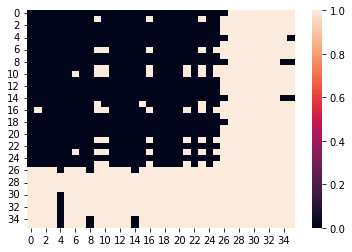

In [199]:
bla = slg.util.matrix_maker(elements,elements,raw_ortho)
import seaborn as sns
ax = sns.heatmap(bla)

In [200]:
ortho_dict = defaultdict(list)
for l,r in raw_ortho:
    ortho_dict[l]+=[r]
print(ortho_dict)

defaultdict(<class 'list'>, {'a': ['1', '2', '3', '4', '5', '6', '7', '8', '9'], 'b': ['j', 'q', 'x', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'c': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'd': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'e': ['1', '2', '3', '4', '5', '6', '7', '8'], 'f': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'g': ['j', 'k', 'q', 'x', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'h': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'i': ['1', '2', '3', '4', '5', '6', '7'], 'j': ['j', 'k', 'q', 'v', 'x', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'k': ['g', 'j', 'k', 'q', 'v', 'x', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'l': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'm': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'n': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'o': ['1', '2', '3', '4', '5', '6', '7'], 'p': ['j', 'p', 'x', '0', '1', '2', '3', '4', '5', '6', 

In [142]:
similarity_matrix[pairs_index["pl"]]

[array([191, 655, 708,   0]),
 array([227, 655, 254,   0]),
 array([409, 655, 293,   0]),
 array([403, 655, 250,   0]),
 array([172, 655, 710,   0]),
 array([189, 655, 281,   0]),
 array([209, 655, 261,   0]),
 array([136, 655, 315,   0]),
 array([306, 655, 500,   0]),
 array([107, 655, 231,   0]),
 array([158, 655, 236,   0]),
 array([676, 655,   0,   0]),
 array([360, 655, 290,   0]),
 array([690, 655, 255,   0]),
 array([148, 655, 567,   0]),
 array([277, 655, 323,   0]),
 array([101, 655, 220,   0]),
 array([597, 655, 227,   0]),
 array([758, 655, 480,   0]),
 array([863, 655, 370,   0]),
 array([283, 655, 349,   0]),
 array([112, 655, 210,   0]),
 array([217, 655, 254,   0]),
 array([160, 655, 218,   0]),
 array([341, 655, 302,   0]),
 array([131, 655, 223,   0]),
 array([123, 655, 528,   0]),
 array([341, 655, 643,   0]),
 array([274, 655, 641,   0]),
 array([236, 655, 586,   0]),
 array([212, 655, 544,   0]),
 array([179, 655, 548,   0]),
 array([185, 655, 507,   0]),
 array([17

In [114]:
term1 = "ab"
term2 = "cd"

vec1 = connective_data_full[:,pairs_index[term1]]
vec2 = connective_data_full[:,pairs_index[term2]]

In [116]:
vec1

array([[6.89875389e-04, 4.30686490e-03, 1.25650532e-01, 7.27839062e-03],
       [7.86490863e-04, 1.83521621e-02, 1.33356536e-01, 7.67228194e-02],
       [1.72747893e-04, 7.97380279e-03, 3.45058512e-03, 1.37541213e-01],
       ...,
       [0.00000000e+00, 1.21802680e-04, 2.43605359e-04, 3.49329033e-03],
       [0.00000000e+00, 0.00000000e+00, 3.01932367e-04, 6.92131880e-03],
       [0.00000000e+00, 7.69171602e-05, 0.00000000e+00, 4.82842087e-03]])

In [111]:
vec1 = np.array([.75,0,.25,0])
vec2 = np.array([1,1,0,1])

In [112]:
sum(np.abs(vec1-vec2))/4

0.625

In [ ]:
vec1[0].dot(vec2[0])

AttributeError: 'numpy.int64' object has no attribute 'dot'

In [66]:
vec2[0]

array([2.12875834e-04, 1.39170424e-01, 3.49213151e-01, 7.27839062e-03])